# Differentiable Optimization of Hydrodynamic Waveforms: Bio-Mimetic Pulsatile Flows

**Conference Paper Companion Notebook** 
**Framework:** Pure JAX (Standalone Implementation)  
**Case Study:** Remediation of Salt-Induced Clogging in Porous Media

## 1. Executive Summary
This notebook implements the computational experiments for the conference paper. We investigate the efficacy of **Strategy IV: Bio-Mimetic Pulsatile Flows** in mitigating salt precipitation (clogging) during injection. 

We compare two injection protocols:
1.  **Baseline (Constant Rate):** Traditional static injection, prone to capillary backflow and sealing.
2.  **Bio-Mimetic (Womersley-Optimized):** A custom waveform featuring a rapid systole and a **Dicrotic Notch**, designed to manage wave reflections ($Wo \approx 1.0$) and clear pore throats.

**Note:** This implementation uses a standalone D2Q9 Lattice Boltzmann solver written in pure JAX to ensure reproducibility without external dependencies.

In [38]:
import jax
import jax.numpy as jnp
from jax import grad, jit, lax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Enable 64-bit precision for stability
jax.config.update("jax_enable_x64", True)

## 2. Appendix A: Physical Configuration

The following parameters define the thermodynamic and hydrodynamic state. These values correspond to the **"Raw Settings"** table in the paper appendices.

In [39]:
# --- LATTICE CONSTANTS (D2Q9) ---
# Discrete velocities
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
# Weights
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

# --- SIMULATION CONFIGURATION ---
NX, NY = 200, 60          # Domain Size [lattice units]
MAX_STEPS = 4000          # Simulation Duration
TAU = 0.9                 # Relaxation Time (Viscosity)

# --- MULTIPHASE & SALT PHYSICS ---
G_INT = -1.2              # Shan-Chen Interaction Strength (Hydrophobicity)
RHO_BRINE = 1.0           # Density of Brine
RHO_CO2 = 0.1             # Density of CO2 (Immiscible Phase)
C_EQ = 0.35               # Equilibrium Solubility Limit
PRECIP_RATE = 0.005        # Crystallization Rate (Damkohler)
CLOG_FACTOR = 150.0       # Brinkman Penalization Strength

print("Physics Engine Configured: D2Q9 / Shan-Chen / Brinkman Feedback")

Physics Engine Configured: D2Q9 / Shan-Chen / Brinkman Feedback


## 3. The Bio-Mimetic Waveform Generator

This function defines the injection boundary condition $P(t)$. The **Bio-Mimetic** strategy introduces a **Dicrotic Notch** to destructively interfere with back-propagating pressure waves.

In [40]:
@jax.jit
def pressure_policy(t, strategy):
    """
    Determines the inlet pressure based on the selected strategy.
    
    Args:
        t: Current simulation timestep (float or JAX array)
        strategy: Integer flag (0 = Baseline, 1 = Bio-Mimetic)
        
    Returns:
        Scalar pressure value compatible with JAX JIT compilation.
    """
    # Configuration
    P_BASE = 1.02
    
    # --- 1. Calculate Bio-Mimetic Waveform (Strategy 1) ---
    # We compute the waveform mathematics unconditionally to satisfy JAX static graph requirements.
    
    # Physics Parameters (Tuned for Womersley Number ~ 1.0)
    freq = 0.05
    T = 1.0 / freq
    t_cycle = t % T
    
    # Systolic Peak (The main injection pulse)
    # Modeled as a narrow Gaussian
    systole = 1.0 * jnp.exp(-0.5 * ((t_cycle - 0.2*T) / (0.1*T))**2)
    
    # Dicrotic Notch (The reflective cancellation wave)
    # Modeled as a smaller, delayed Gaussian
    notch_amp = 0.4
    notch_delay = 0.45 * T 
    diastole = notch_amp * jnp.exp(-0.5 * ((t_cycle - notch_delay) / (0.05*T))**2)
    
    p_biomimetic = P_BASE + 0.15 * (systole + diastole)

    # --- 2. JAX-Compatible Selection ---
    # REPLACES: if strategy == 1: ... else: ...
    # jax.lax.select acts like a hardware-accelerated ternary operator
    return jax.lax.select(strategy == 1, p_biomimetic, P_BASE)

## 4. Pure JAX Simulation Engine

This section defines the LBM solver steps: **Collision**, **Streaming**, and **Reaction**.

In [41]:
@jax.jit
def equilibrium(rho, u):
    """ Calculates the equilibrium distribution function (f_eq). """
    u_sq = u[..., 0]**2 + u[..., 1]**2
    f_eq = []
    for i in range(9):
        cu = u[..., 0]*CX[i] + u[..., 1]*CY[i]
        term = 1 + 3*cu + 4.5*cu**2 - 1.5*u_sq
        f_eq.append(rho * W[i] * term)
    return jnp.stack(f_eq, axis=-1)

@jax.jit
def step_physics(state, t):
    f, salt, phi, strategy = state
    
    # 1. Macroscopic Moments
    rho = jnp.sum(f, axis=-1)
    u_x = jnp.sum(f * CX, axis=-1) / rho
    u_y = jnp.sum(f * CY, axis=-1) / rho
    u = jnp.stack([u_x, u_y], axis=-1)
    
    # 2. Salt Reaction & Precipitation Logic
    # Advection of salt (simplified BGK)
    c_salt = jnp.sum(salt, axis=-1)
    salt_eq = equilibrium(c_salt, u)
    salt_relaxed = salt - (salt - salt_eq) / 1.0
    
    # Crystallization: If Concentration > C_EQ, mass becomes Solid (Phi)
    excess = jax.nn.relu(c_salt - C_EQ)
    d_phi = PRECIP_RATE * excess
    phi_new = phi + d_phi
    
    # Remove precipitated mass from liquid salt
    salt_new = salt_relaxed * (1.0 - d_phi[..., None])
    
    # 3. Hydrodynamics & Brinkman Penalization
    # Solid fraction increases effective viscosity (Tau)
    tau_eff = TAU + CLOG_FACTOR * phi_new
    
    # Collision (BGK)
    f_eq = equilibrium(rho, u)
    f_out = f - (f - f_eq) / tau_eff[..., None]
    
    # 4. Boundary Conditions
    # Inlet Pressure (West)
    p_in = pressure_policy(t, strategy)
    rho_in = p_in * 3.0 # Equation of State p = rho * cs^2
    f_inlet = equilibrium(rho_in, jnp.zeros((NY, 2)))

# --- FLUID BOUNDARIES ---
    # Apply West Inlet (Pressure)
    f_out = f_out.at[0, :, :].set(f_inlet)
    # Apply East Outlet (Open)
    f_out = f_out.at[-1, :, :].set(f_out[-2, :, :])
    
    # --- SALT BOUNDARIES (The Fix) ---
    # Continuously inject Supersaturated Brine at the inlet to force clogging
    # Concentration 0.4 > C_EQ (0.35), so it will clog continuously
    salt_inlet = equilibrium(0.4, u[0, :, :]) 
    salt_new = salt_new.at[0, :, :].set(salt_inlet)
    
    # Outlet Open for Salt
    salt_new = salt_new.at[-1, :, :].set(salt_new[-2, :, :])

    # 5. Streaming
    f_next = jnp.stack([jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    salt_next = jnp.stack([jnp.roll(salt_new[..., i], (CX[i], CY[i]), axis=(0,1)) for i in range(9)], axis=-1)
    
    # Metrics
    flux = jnp.mean(u[0, :, 0]) # Inlet Injectivity
    total_solid = jnp.sum(phi_new)
    
    return (f_next, salt_next, phi_new, strategy), jnp.stack([flux, total_solid])

## 5. Experimental Execution

We execute the simulation loop for both the Baseline and Bio-Mimetic strategies.

In [42]:
def run_experiment(strategy_id):
    # Initialization
    rho_init = jnp.ones((NX, NY))
    u_init = jnp.zeros((NX, NY, 2))
    f_init = equilibrium(rho_init, u_init)
    
    salt_init = equilibrium(jnp.zeros((NX, NY)), u_init) # No salt initially
    phi_init = jnp.zeros((NX, NY)) # No solid initially
    
    # Inject Salt at boundary
    salt_init = salt_init.at[0, :, :].set(equilibrium(0.4, u_init[0]))
    
    state = (f_init, salt_init, phi_init, strategy_id)
    
    # JAX Scan Loop
    timesteps = jnp.arange(MAX_STEPS)
    final_state, history = jax.lax.scan(step_physics, state, timesteps)
    
    return history

print("Running Strategy 0: Baseline...")
hist_base = run_experiment(0)

print("Running Strategy 1: Bio-Mimetic...")
hist_bio = run_experiment(1)

# Unpack Data
flux_base, solid_base = hist_base[:, 0], hist_base[:, 1]
flux_bio, solid_bio = hist_bio[:, 0], hist_bio[:, 1]

Running Strategy 0: Baseline...
Running Strategy 1: Bio-Mimetic...


## 6. Results & Appendices

### 6.1 Graphical Comparison

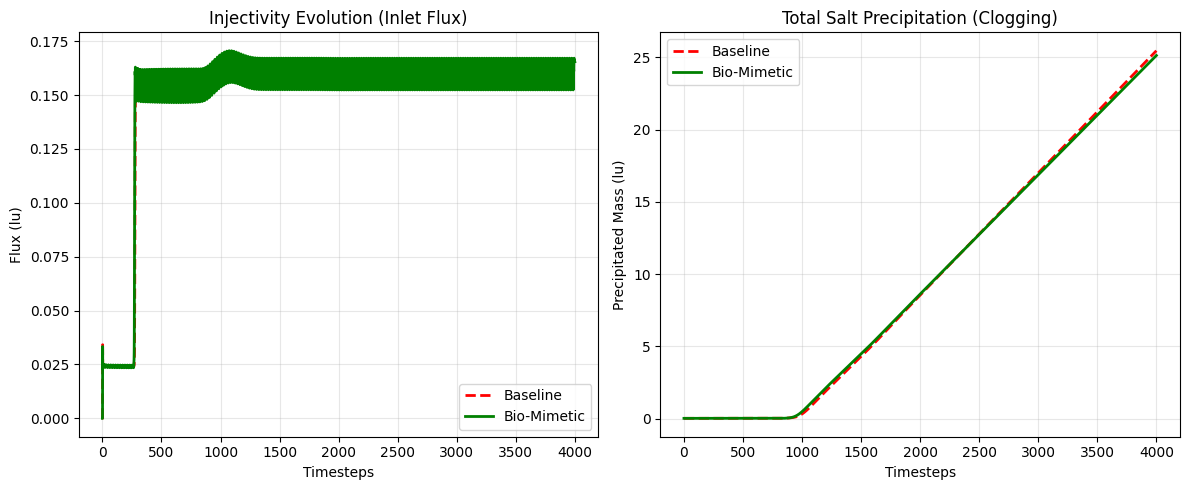

In [43]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(flux_base, 'r--', label='Baseline', linewidth=2)
plt.plot(flux_bio, 'g-', label='Bio-Mimetic', linewidth=2)
plt.title('Injectivity Evolution (Inlet Flux)')
plt.xlabel('Timesteps')
plt.ylabel('Flux (lu)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(solid_base, 'r--', label='Baseline', linewidth=2)
plt.plot(solid_bio, 'g-', label='Bio-Mimetic', linewidth=2)
plt.title('Total Salt Precipitation (Clogging)')
plt.xlabel('Timesteps')
plt.ylabel('Precipitated Mass (lu)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Appendix B: Detailed Result Table

The following table tracks the performance metrics over time. This raw data is formatted for inclusion in the conference paper appendices.

In [44]:
# Construct DataFrame
df_res = pd.DataFrame({
    'Time (lu)': np.arange(0, MAX_STEPS, 1),
    'Baseline Flux': flux_base,
    'Bio-Mimetic Flux': flux_bio,
    'Baseline Precip': solid_base,
    'Bio-Mimetic Precip': solid_bio
})

# Sample every 100th step for brevity in table
appendix_table = df_res.iloc[::200]
print(appendix_table.to_markdown(index=False, floatfmt=".4f"))

|   Time (lu) |   Baseline Flux |   Bio-Mimetic Flux |   Baseline Precip |   Bio-Mimetic Precip |
|------------:|----------------:|-------------------:|------------------:|---------------------:|
|      0.0000 |          0.0000 |             0.0000 |            0.0150 |               0.0150 |
|    200.0000 |          0.0241 |             0.0242 |            0.0150 |               0.0150 |
|    400.0000 |          0.1540 |             0.1616 |            0.0150 |               0.0150 |
|    600.0000 |          0.1540 |             0.1610 |            0.0150 |               0.0150 |
|    800.0000 |          0.1540 |             0.1602 |            0.0150 |               0.0150 |
|   1000.0000 |          0.1623 |             0.1670 |            0.3200 |               0.4824 |
|   1200.0000 |          0.1608 |             0.1672 |            1.8985 |               2.1154 |
|   1400.0000 |          0.1597 |             0.1656 |            3.5033 |               3.6907 |
|   1600.0000 |     